<a href="https://colab.research.google.com/github/nbespinosa/Derma_challenge/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy


In [ ]:
pip install pygame


In [ ]:
pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
import sklearn

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
a=load_img('ISIC_0031023.jpg',target_size=(224, 224))
tensor=img_to_array(a)
print(tensor)

[[[20.  8. 18.]
  [18.  5. 14.]
  [13.  4.  9.]
  ...
  [51. 28. 44.]
  [47. 27. 39.]
  [51. 31. 42.]]

 [[20.  8. 18.]
  [21.  9. 19.]
  [18.  6. 16.]
  ...
  [53. 30. 48.]
  [57. 34. 52.]
  [51. 28. 44.]]

 [[18. 11. 19.]
  [20.  8. 18.]
  [19.  8. 16.]
  ...
  [49. 24. 43.]
  [46. 25. 42.]
  [50. 32. 46.]]

 ...

 [[39. 23. 33.]
  [43. 25. 39.]
  [46. 25. 42.]
  ...
  [11.  6. 13.]
  [15.  5. 14.]
  [14.  7. 14.]]

 [[44. 24. 36.]
  [41. 23. 39.]
  [38. 20. 34.]
  ...
  [10.  5.  9.]
  [10.  5. 11.]
  [15.  3. 13.]]

 [[48. 28. 40.]
  [49. 28. 43.]
  [42. 24. 38.]
  ...
  [12.  7. 13.]
  [16. 10. 14.]
  [12.  7. 13.]]]


In [ ]:
pip install opencv-contrib-python

In [16]:
import cv2
print(cv2.__version__)

4.10.0


In [15]:
#DullRazor
import cv2
from google.colab import files

In [17]:
#Input image
path='/content/ISIC_0031023.jpg'

In [18]:
#Read image
image=cv2.imread(path,cv2.IMREAD_COLOR)

In [19]:
#Image cropping
img=image[30:410,30:560]

In [20]:
#Gray scale
grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )

In [21]:
#Black hat filter
kernel = cv2.getStructuringElement(1,(9,9))
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

In [22]:
#Gaussian filter
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

In [23]:
#Binary thresholding (MASK)
ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)

In [24]:
#Replace pixels of the mask
dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)

In [ ]:
#Display images
from google.colab.patches import cv2_imshow

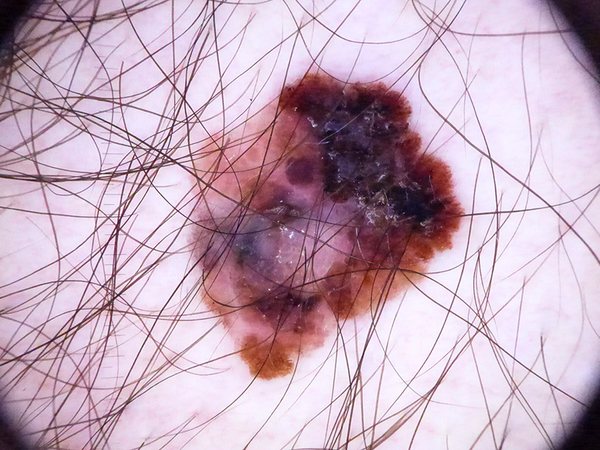

In [ ]:
cv2_imshow(image)

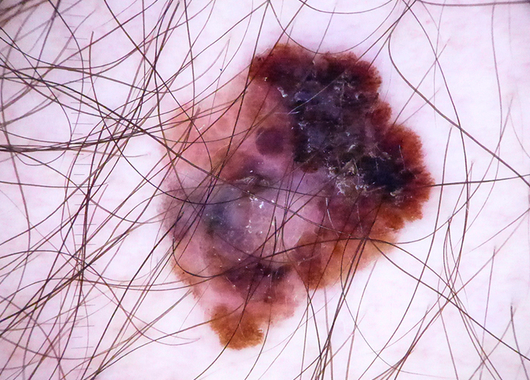

In [ ]:
cv2_imshow(img)

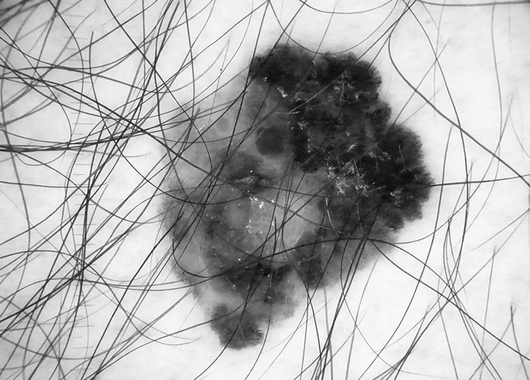

In [ ]:
cv2_imshow(grayScale)

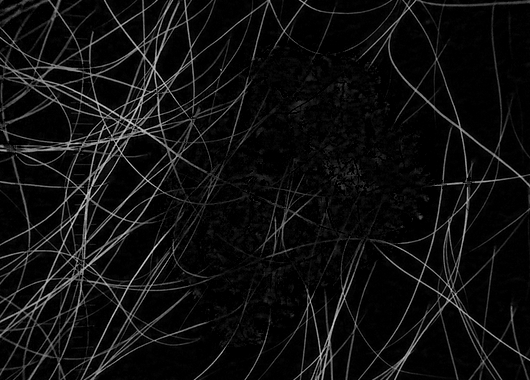

In [ ]:
cv2_imshow(blackhat)

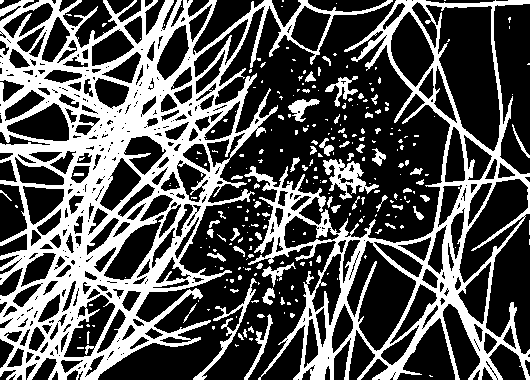

In [ ]:
cv2_imshow(mask)

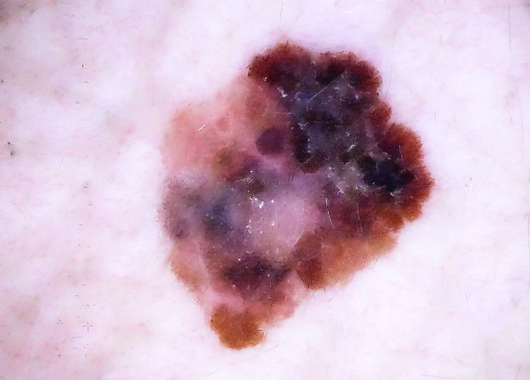

In [ ]:
cv2_imshow(dst)

In [ ]:
import os
import cv2
import skimage
import sklearn
import scipy
import matplotlib
import PIL
import tensorflow as tf

from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import sobel
from skimage import morphology, measure, segmentation, exposure, color
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from scipy.ndimage import uniform_filter

from PIL import Image

from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [ ]:
%matplotlib inline

print('PIL version : 9.0.1',
'cv2 version : 4.5.4',
'skimage version : 0.19.2',
'sklearn version : 1.0.2',
'scipy version : 1.7.3',
'pandas version : 1.3.5',
'matplotlib version : 3.5.1',
'seaborn version : 0.11.2',
'tensorflow version : 2.6.3',
'xgboost version : 1.6.0')

PIL version : 9.0.1 cv2 version : 4.5.4 skimage version : 0.19.2 sklearn version : 1.0.2 scipy version : 1.7.3 pandas version : 1.3.5 matplotlib version : 3.5.1 seaborn version : 0.11.2 tensorflow version : 2.6.3 xgboost version : 1.6.0


In [ ]:
#Convertir una imagen de formato RGB (Rojo, Verde, Azul) a formato YIQ, que es útil para el umbral adaptativo
#el umbral adaptativo se utiliza para segmentar imágenes de diagnóstico, como las dermatoscópicas, mejorando la identificación de lesiones y estructuras relevantes en condiciones de iluminación no uniforme
def rgb2yiq(imgArray):
    '''
    Simple mathematical operation for Adaptative thresholding implementation
    '''
    assert (imgArray.shape[2] == 3)
    l = imgArray.shape[0]
    L = imgArray.shape[1]

    YIQ = np.zeros((l, L, 3))
    YIQ[:,:,0] = (0.299 * imgArray[:,:,0] + 0.587 * imgArray[:,:,1] + 0.114 * imgArray[:,:,2])
    YIQ[:,:,1] = 0.596 * imgArray[:,:,0] - 0.274 * imgArray[:,:,1] - 0.322 * imgArray[:,:,2]
    YIQ[:,:,2] = 0.211 * imgArray[:,:,0] - 0.523 * imgArray[:,:,1] + 0.312 * imgArray[:,:,2]
    return np.asarray(YIQ)

In [ ]:
import numpy as np
from PIL import Image

# Llamar a la función
yiq_image = rgb2yiq(dst)

# Imprimir el resultado
print(yiq_image)



NameError: name 'rgb2yiq' is not defined

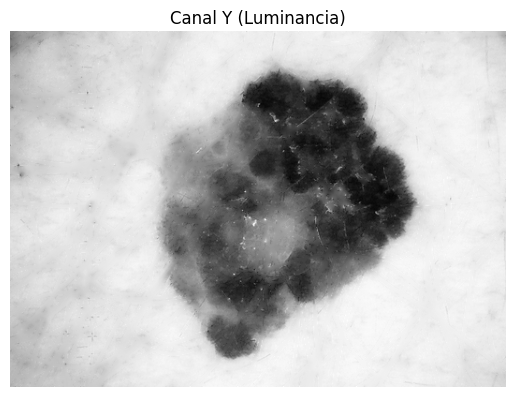

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que yiq_image es el resultado de la conversión a YIQ
# Visualizar el canal Y (luminancia)
plt.imshow(yiq_image[:, :, 0], cmap='gray')  # Muestra el canal Y
plt.title('Canal Y (Luminancia)')
plt.axis('off')  # Oculta los ejes
plt.show()

In [ ]:
#realiza una operación matemática sobre una imagen en escala de grises (black and white) para preparar los datos para un proceso de umbral adaptativo
#lo blanco lo pone negro y viceversa
def invertPixelsMinusMean(blackAndWhite):
  inverted = (blackAndWhite.max() - blackAndWhite)
  inverted = inverted - inverted.mean()
  inverted[inverted < 0] = 0
  return inverted

inverted_image = invertPixelsMinusMean(grayScale)
print(inverted_image)

[[ 98.4533565 111.4533565  95.4533565 ...  69.4533565  72.4533565
   78.4533565]
 [103.4533565  96.4533565  52.4533565 ...  72.4533565  88.4533565
   98.4533565]
 [ 93.4533565  63.4533565  43.4533565 ...  69.4533565  72.4533565
   85.4533565]
 ...
 [  0.          4.4533565   0.        ...  34.4533565   0.
    0.       ]
 [  3.4533565   0.4533565   0.        ...  27.4533565  16.4533565
    0.       ]
 [  0.          0.          0.        ...  12.4533565  29.4533565
    0.       ]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Visualizar la imagen
plt.imshow(inverted_image, cmap='gray')  # Usar cmap='gray' para imágenes en escala de grises
plt.title('Imagen Invertida')
plt.axis('off')  # Oculta los ejes
plt.show()

NameError: name 'inverted_image' is not defined

In [ ]:
#aplica un filtro de promedio (o filtro de suavizado) a una imagen para reducir el ruido y suavizarla
def averageFilter(img, filterSize):
  if (filterSize == 0):
    return img
  else:
    kernel = np.ones((filterSize, filterSize), np.float32) / (filterSize**2)
    less_noise = cv2.filter2D(img, -1, kernel)
  return less_noise

without_noise = averageFilter(dst, 3)
print(without_noise)

[[[139 127 156]
  [140 128 157]
  [140 129 158]
  ...
  [196 171 194]
  [195 171 194]
  [194 170 193]]

 [[139 127 156]
  [139 127 156]
  [139 127 156]
  ...
  [195 171 194]
  [194 171 194]
  [194 170 193]]

 [[138 126 155]
  [138 126 155]
  [137 125 154]
  ...
  [194 170 193]
  [193 169 192]
  [192 168 191]]

 ...

 [[186 168 197]
  [189 169 198]
  [190 170 197]
  ...
  [224 208 225]
  [224 207 225]
  [224 207 225]]

 [[189 168 200]
  [190 169 201]
  [191 171 200]
  ...
  [225 208 226]
  [224 208 226]
  [224 207 225]]

 [[189 167 203]
  [190 169 203]
  [192 171 202]
  ...
  [225 208 226]
  [225 208 226]
  [225 208 226]]]


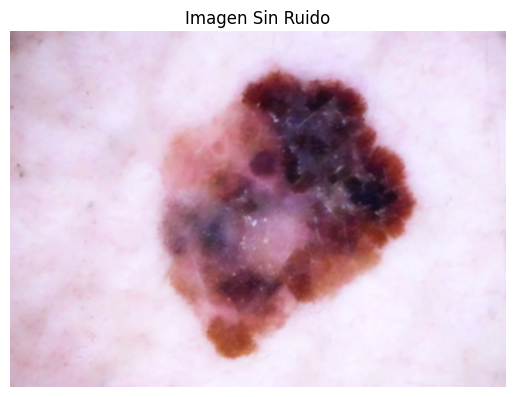

In [ ]:
plt.imshow(cv2.cvtColor(without_noise, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.title('Imagen Sin Ruido')
plt.axis('off')  # Ocultar los ejes
plt.show()

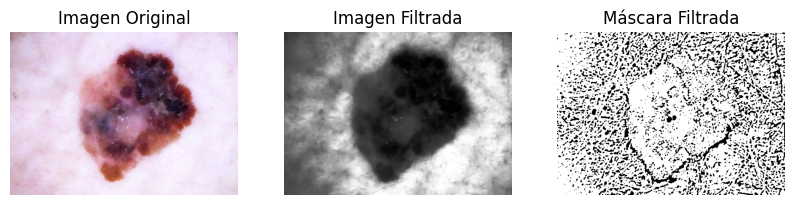

In [ ]:
#extrae la región más grande de una imagen binaria (máscara) que cumple con ciertos criterios de área
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Definir la función bwareafilt
def bwareafilt(mask, n=1, area_range=(0, np.inf)):
    labels = measure.label(mask.astype('uint8'), background=0)
    area_idx = np.arange(1, np.max(labels) + 1)
    areas = np.array([np.sum(labels == i) for i in area_idx])
    inside_range_idx = np.logical_and(areas >= area_range[0], areas <= area_range[1])
    area_idx = area_idx[inside_range_idx]
    areas = areas[inside_range_idx]
    keep_idx = area_idx[np.argsort(areas)[::-1][0:n]]
    kept_areas = areas[np.argsort(areas)[::-1][0:n]]

    if np.size(kept_areas) == 0:
        kept_areas = np.array([0])
    if n == 1:
        kept_areas = kept_areas[0]
    kept_mask = np.isin(labels, keep_idx)

    return kept_mask

# Convertir la imagen a escala de grises
gray_image = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

# Mejorar el contraste usando ecualización del histograma
equalized_image = cv2.equalizeHist(gray_image)

# Aplicar un filtro Gaussiano para reducir el ruido
filtered_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Aplicar un umbral adaptativo para crear una máscara binaria
binary_mask = cv2.adaptiveThreshold(filtered_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

# Llamar a la función bwareafilt
filtered_mask = bwareafilt(binary_mask, n=1, area_range=(100, np.inf))  # Ajusta el área según sea necesario

# Visualizar la imagen original y la máscara filtrada
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Imagen Filtrada')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Máscara Filtrada')
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')

plt.show()



In [ ]:
def dullrazor(img, lowbound=5, filterstruc=7, inpaintmat=5):

    '''
    Erases the hair from a skin image
    '''
    #grayscale
    imgtmp1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #applying a blackhat
    filterSize =(filterstruc, filterstruc)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)
    imgtmp2 = cv2.morphologyEx(imgtmp1, cv2.MORPH_BLACKHAT, kernel)

    #0=skin and 255=hair
    ret, mask = cv2.threshold(imgtmp2, lowbound, 255, cv2.THRESH_BINARY)

    #inpainting
    img_final = cv2.inpaint(img, mask, inpaintmat ,cv2.INPAINT_TELEA)

    return img_final

without_hairs = dullrazor(image, lowbound=5, filterstruc=7, inpaintmat=5)
print(without_hairs)

[[[22 12 24]
  [19  9 21]
  [16  6 18]
  ...
  [42 30 50]
  [42 30 50]
  [45 30 51]]

 [[18 10 20]
  [18  8 20]
  [16  6 18]
  ...
  [45 34 54]
  [42 31 51]
  [43 31 51]]

 [[18  8 20]
  [17  7 19]
  [17  8 18]
  ...
  [48 35 57]
  [45 32 54]
  [46 32 53]]

 ...

 [[41 29 49]
  [45 30 51]
  [40 26 44]
  ...
  [11  7 12]
  [ 9  5 10]
  [13  7 14]]

 [[39 27 47]
  [40 28 48]
  [46 31 52]
  ...
  [12  8 13]
  [13  7 12]
  [ 9  5 11]]

 [[41 27 47]
  [40 27 47]
  [43 28 49]
  ...
  [11  7 12]
  [13  6 11]
  [11  5 10]]]


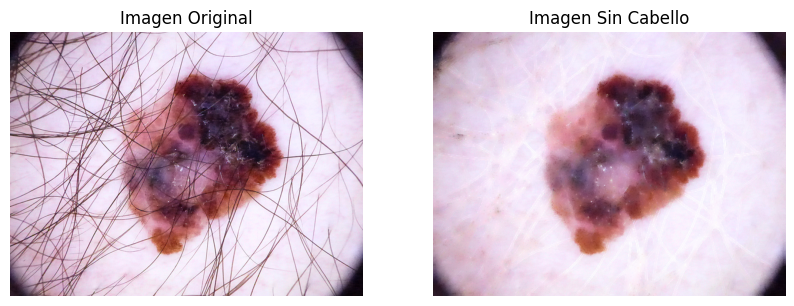

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Sin Cabello')
plt.imshow(cv2.cvtColor(without_hairs, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
plt.axis('off')

plt.show()

In [ ]:
def AdaptiveTresholding(imgName, averageFilterSize=0):
    '''
    Computes the segmentation of an image
    img : np.ndarray, the image array
    averageFilterSize : int, size of the averaging filter kernel if different than 0
    '''

    # Convertir la imagen a un array NumPy
    arrayImg = img

    # Step 1 : extract luminance, first channel of YIQ
    luminance = rgb2yiq(dullrazor(arrayImg))[:,:,0]

    # Step 2 and 3 : apply transformations and denoise
    processedLuminance = invertPixelsMinusMean(luminance)
    processedLuminance = np.uint8(processedLuminance)
    processedLuminance = cv2.fastNlMeansDenoising(processedLuminance)
    averaged = averageFilter(processedLuminance, averageFilterSize)


    # bwareafilt extracts the largest white area of binary img
    # Step 4 : Compute the binary image
    binaryImage = bwareafilt(averaged > averaged.std() / 2, area_range = (0, averaged.shape[0]*averaged.shape[1]/2)) # Chooses the largest segmented part


    # If the image border are black : new heuristically chosen segmentation method. The picture is first cropped then converted to black and white,
    # The distance from the mean of the new image is computed and its edges are calculated. An averaging filter is then applied and the image is inverted before thresholding.
    if (binaryImage[0:15,:]).all() and (binaryImage[:,0:15]).all() and (binaryImage[-16:-1,:]).all() and (binaryImage[:,-16:-1]).all():

        i=15
        while((binaryImage[i,:]).all()):
            i+=1
        j=15
        while((binaryImage[:,j]).all()):
            j+=1

        grayscale = color.rgb2gray(arrayImg)
        grayscale = grayscale[i:grayscale.shape[0]-i,j:grayscale.shape[1]-j]

        edge = sobel(grayscale)

        meann = grayscale.mean()
        processedImg = averageFilter(edge, 20)

        processedImg = meann - abs(grayscale - meann)
        processedImg = averageFilter(processedImg, 10)
        processedImg = 1 - processedImg

        binaryImage = bwareafilt(processedImg > processedImg.mean(), area_range = (0, binaryImage.shape[0]*binaryImage.shape[1]/2))


    # Step 5 : filling holes
    des = cv2.bitwise_not(binaryImage*255)
    contour,hier = cv2.findContours(binaryImage*255,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(des,[cnt],0,255,-1)

    return des


w_img = AdaptiveTresholding(tensor, averageFilterSize = 7)
print(w_img)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


NameError: name 'w_img' is not defined

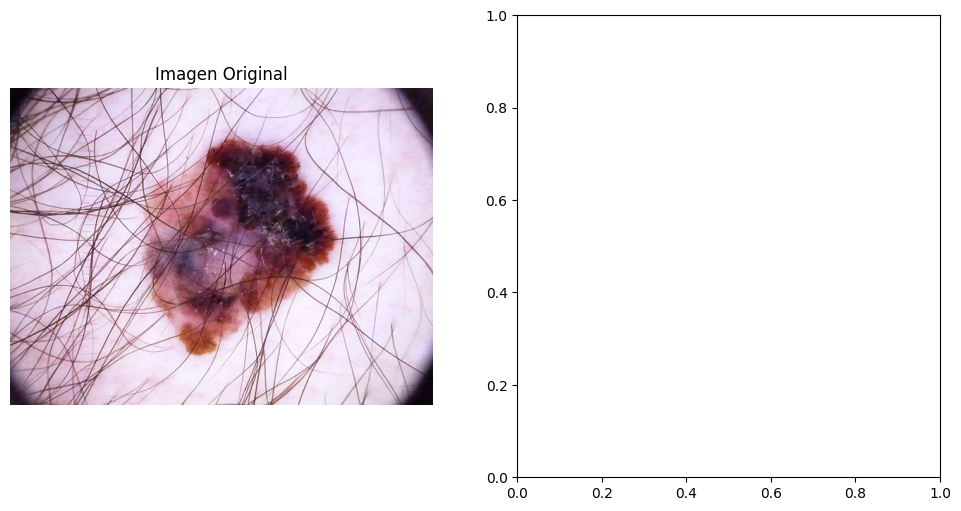

In [ ]:
# Visualizar la imagen original y la imagen procesada
plt.figure(figsize=(12, 6))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
plt.axis('off')

# Mostrar la imagen procesada
plt.subplot(1, 2, 2)
plt.imshow(w_img, cmap='gray')  # Usar cmap='gray' para imágenes en escala de grises
plt.title('Imagen Procesada')
plt.axis('off')  # Ocultar los ejes

plt.tight_layout()  # Ajustar el espaciado entre subgráficas
plt.show()

In [ ]:
from PIL import Image
import numpy as np
from skimage.measure import label, regionprops_table
from scipy.ndimage import uniform_filter

def getProps(img, seg=False):
    '''
    Returns the geometrical properties of an anomaly given a pre-loaded image or an image file path.
    img : str or np.ndarray, the image file path or the image array
    seg : boolean, the segmentation performed by clinicians is selected when it exists, which is told with seg
    '''
    # Verificar si img es una cadena (ruta del archivo) o un array NumPy
    if isinstance(img, str):
        # Si es una ruta de archivo, abrir la imagen y convertirla a un array NumPy
        img = np.asarray(Image.open(img))

    # Si se proporciona una segmentación manual
    if seg:
        # Aquí puedes agregar lógica para cargar imágenes segmentadas si es necesario
        smoothImg = img  # Usar la imagen directamente si se proporciona la segmentación

    else:
        # Realizar la segmentación automática
        segImg = AdaptiveTresholding(img, averageFilterSize=5)
        smoothImg = uniform_filter(segImg, size=3)

    # Extraer propiedades geométricas de la imagen binaria usando regionprops_table
    label_img = label(smoothImg)
    properties = regionprops_table(label_img, properties=('area',
                                                           'axis_major_length',
                                                           'axis_minor_length',
                                                           'eccentricity',
                                                           'equivalent_diameter_area',
                                                           'extent',
                                                           'feret_diameter_max',
                                                           'inertia_tensor',
                                                           'moments_hu',
                                                           'perimeter'))

    return pd.DataFrame(properties).iloc[0]

results = getProps(tensor, seg=False)
print(results)

area                        1.468550e+05
axis_major_length           6.951188e+02
axis_minor_length           4.832659e+02
eccentricity                7.187895e-01
equivalent_diameter_area    4.324137e+02
extent                      7.291708e-01
feret_diameter_max          6.515681e+02
inertia_tensor-0-0          3.018534e+04
inertia_tensor-0-1         -4.677887e+02
inertia_tensor-1-0         -4.677887e+02
inertia_tensor-1-1          1.461066e+04
moments_hu-0                3.050356e-01
moments_hu-1                1.128822e-02
moments_hu-2                5.699406e-05
moments_hu-3                2.281513e-04
moments_hu-4                2.556589e-08
moments_hu-5                2.405681e-05
moments_hu-6               -4.821279e-09
perimeter                   2.875159e+03
Name: 0, dtype: float64


In [ ]:
results = getProps(w_img, seg=True)
print(results)

area                        1.480090e+05
axis_major_length           6.931431e+02
axis_minor_length           4.825958e+02
eccentricity                7.178065e-01
equivalent_diameter_area    4.341093e+02
extent                      7.349007e-01
feret_diameter_max          6.515681e+02
inertia_tensor-0-0          3.001457e+04
inertia_tensor-0-1         -4.550234e+02
inertia_tensor-1-0         -4.550234e+02
inertia_tensor-1-1          1.456956e+04
moments_hu-0                3.012258e-01
moments_hu-1                1.092710e-02
moments_hu-2                5.308671e-05
moments_hu-3                2.141253e-04
moments_hu-4                2.242152e-08
moments_hu-5                2.219299e-05
moments_hu-6               -4.296240e-09
perimeter                   2.859845e+03
Name: 0, dtype: float64


In [ ]:
def getRGBstats(imPath):
    '''
    Computes basic stats of the histogram of an image
    '''
    img = np.array(Image.open(imPath))
    redMean, redStd, redMedian = img[:,:,0].mean(), img[:,:,0].std(), np.median(img[:,:,1])
    greenMean, greenStd, greenMedian = img[:,:,1].mean(), img[:,:,1].std(), np.median(img[:,:,1])
    blueMean, blueStd, blueMedian = img[:,:,2].mean(), img[:,:,2].std(), np.median(img[:,:,2])
    return {'redMean': redMean, 'redStd': redStd, 'redMedian': redMedian,
            'greenMean': greenMean, 'greenStd': greenStd, 'greenMedian': greenMedian,
            'blueMean': blueMean, 'blueStd': blueStd, 'blueMedian': blueMedian}

RBGstats = getRGBstats('ISIC_0031023.jpg')
print(RBGstats)

{'redMean': 197.67374074074075, 'redStd': 59.14226325601595, 'redMedian': 205.0, 'greenMean': 171.0144148148148, 'greenStd': 69.90221725666719, 'greenMedian': 205.0, 'blueMean': 188.82694814814815, 'blueStd': 71.64680971226466, 'blueMedian': 226.0}


In [ ]:
#~~~~~~~~~~~~~Dermoscopic-Images-Classifier~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.metrics import geometric_mean_score
#from imblearn.model_selection import GridSearchCVClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt

import cv2

import skimage.io
import csv
import os

from joblib import Parallel, delayed
import multiprocessing
from math import sqrt
import pandas as pd

from tensorflow.keras.models import save_model, load_model

from skimage.measure import shannon_entropy
from skimage.metrics import structural_similarity as compare_ssim
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import joblib

from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader

In [ ]:
def otsuSegmentation(imag):
    grayscale_image = cv2.cvtColor(imag, cv2.COLOR_RGB2GRAY)
    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Assuming arr is your NumPy array
    arr = np.array(segmented_image)

    # Replace 255 with 0 and 0 with 1
    segmented_image = np.where(arr == 255, 0, 1)

    return np.array(segmented_image).astype('uint8')

otsuimg = otsuSegmentation(dst)
print(otsuimg)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


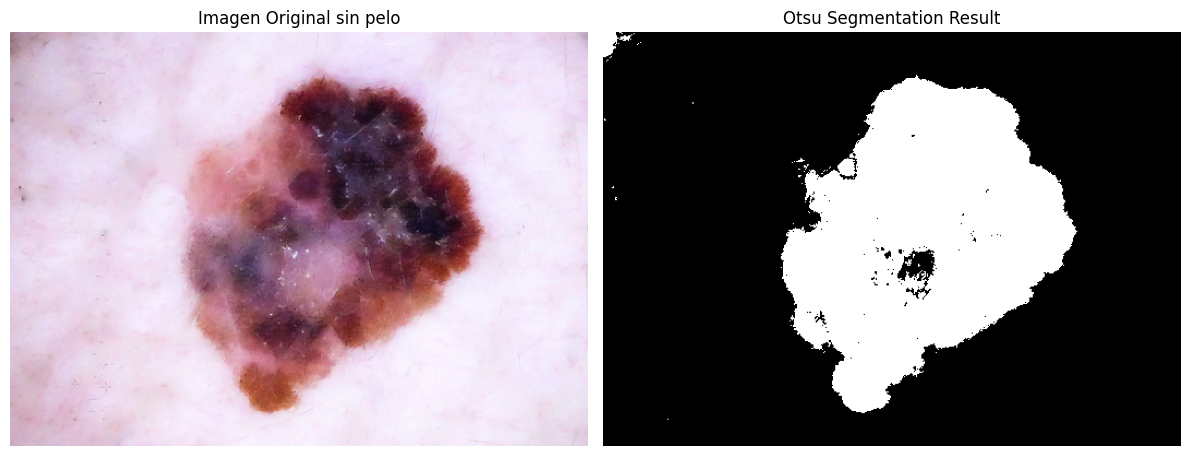

In [ ]:
import matplotlib.pyplot as plt

# Visualizar la imagen original y la imagen procesada
plt.figure(figsize=(12, 6))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.title('Imagen Original sin pelo')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
plt.axis('off')

# Mostrar la imagen procesada
plt.subplot(1, 2, 2)
plt.imshow(otsuimg, cmap='gray') # Usar cmap='gray' para imágenes en escala de grises
plt.title('Otsu Segmentation Result')
plt.axis('off')  # Ocultar los ejes

plt.tight_layout()  # Ajustar el espaciado entre subgráficas
plt.show()

In [25]:
#redimensionar un conjunto de imágenes a un tamaño común
import cv2
from tqdm import tqdm  # Asegúrate de importar tqdm si deseas usar la barra de progreso

def resizeImage(image):
    # Define a common size for resizing the image
    target_size = (500, 300)  # Adjust this size as needed

    # Resize the image
    resized_img = cv2.resize(image, target_size)

    return resized_img

same_size = resizeImage(dst)
print(same_size)

[[[140 128 157]
  [139 127 156]
  [139 128 157]
  ...
  [196 172 195]
  [194 170 194]
  [196 172 195]]

 [[139 128 156]
  [138 126 156]
  [139 128 157]
  ...
  [195 171 194]
  [192 169 192]
  [195 171 194]]

 [[139 126 155]
  [137 124 153]
  [134 122 152]
  ...
  [193 169 193]
  [189 166 189]
  [192 169 192]]

 ...

 [[191 172 198]
  [183 170 192]
  [192 172 198]
  ...
  [224 207 225]
  [223 206 224]
  [224 206 226]]

 [[187 165 201]
  [186 166 197]
  [193 171 199]
  ...
  [225 208 226]
  [225 208 226]
  [224 208 225]]

 [[190 167 201]
  [194 173 205]
  [193 175 206]
  ...
  [225 207 227]
  [224 207 225]
  [224 208 226]]]


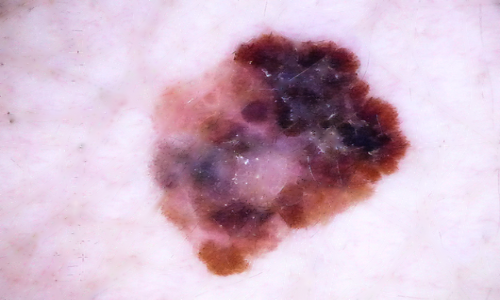

In [ ]:
cv2_imshow(same_size)

In [ ]:
#calcular la asimetría de una imagen mediante el uso del Índice de Similitud Estructural (SSIM)
def calculate_asymmetry(image):
    # Mirror the left half of the image
    mirrored = np.fliplr(image[:, :image.shape[1] // 2, :])
    # Compute structural similarity index (SSIM)
    # Ensure the window size does not exceed the smaller side of the image
    window_size = 3  # You can adjust this window size as needed (e.g., 3x3 or 5x5)
    ssim = compare_ssim(image[:, image.shape[1] // 2:, :], mirrored, multichannel=True, win_size=window_size)
    return ssim
asymmetry = calculate_asymmetry(dst)
print(asymmetry)

0.7084019239498953


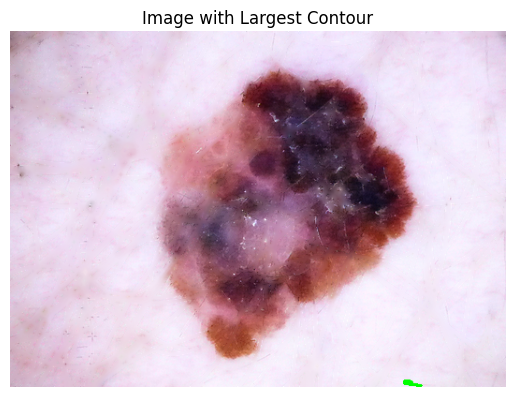

75.20829671286867


In [ ]:
import cv2
import matplotlib.pyplot as plt

def calculate_border_irregularity(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.equalizeHist(gray)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Select the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Compute the perimeter and area of the largest contour
        perimeter = cv2.arcLength(largest_contour, True)
        area = cv2.contourArea(largest_contour)

        # Create a copy of the original image to draw the largest contour on
        image_with_contours = image.copy()

        # Draw only the largest contour in green
        cv2.drawContours(image_with_contours, [largest_contour], -1, (0, 255, 0), 2)  # Draw the largest contour in green

        # Show the image with the largest contour
        plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.title("Image with Largest Contour")
        plt.axis('off')
        plt.show()

        # Calculate compactness (perimeter^2 / area)
        compactness = (perimeter ** 2) / area
        return compactness
    else:
        print("No contours found.")
        return None

# Load the image
ex = cv2.imread('/content/carcinoma-basocelular.jpg')
border_irregularity = calculate_border_irregularity(dst)
print(border_irregularity)


In [ ]:
def calculate_border_irregularity(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.equalizeHist(gray)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 70, 170)

    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis('off')
    plt.show()
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the perimeter of the largest contour
    perimeter = cv2.arcLength(contours[0], True)
    # Compute the area of the largest contour
    area = cv2.contourArea(contours[0])

    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Draw all contours in green
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Image with Largest Contour")
    plt.axis('off')
    plt.show()

    # Calculate compactness (perimeter^2 / area)
    compactness = (perimeter ** 2) / area
    return compactness, plt.show()

ex = cv2.imread('/content/carcinoma-basocelular.jpg')
border_irregularity = calculate_border_irregularity(dst)
print(border_irregularity)

NameError: name 'dst' is not defined

In [ ]:
def calculate_color_features(image):
    # Convert image to Lab color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Split channels
    l, a, b = cv2.split(lab)
    # Calculate mean and standard deviation of each channel
    l_mean, l_std = np.mean(l), np.std(l)
    a_mean, a_std = np.mean(a), np.std(a)
    b_mean, b_std = np.mean(b), np.std(b)
    return l_mean, l_std, a_mean, a_std, b_mean, b_std
    return {'l_mean': l_mean, 'l_std': l_std, 'a_mean': a_mean,
            'greenMean': greenMean, 'greenStd': greenStd, 'greenMedian': greenMedian,
            'blueMean': blueMean, 'blueStd': blueStd, 'blueMedian': blueMedian}

color_features = calculate_color_features(dst)
print(color_features)

{'l_mean': 194.1458093346574, 'l_std': 61.93106156132481, 'a_mean': 141.52601787487586, 'a_std': 8.588425985321225, 'b_mean': 123.16812810327706, 'b_std': 7.108583289013136}


In [ ]:
def calculateABCD(image):
    asymmetry_score = calculate_asymmetry(image)
    l_mean, l_std, a_mean, a_std, b_mean, b_std = calculate_color_features(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    area, aspect_ratio = calculate_dimension(gray_image)
    return [asymmetry_score, l_mean, l_std, a_mean, a_std, b_mean, b_std, area, aspect_ratio]

In [ ]:
import cv2

# Function to calculate the Dice score for a single image segmentation
def calculateDiceForSingleImage(image, segmentation_mask):
    # Initialize variables for calculating the Dice score
    total_dice_score = 0

    # Check if segmentation mask exists
    if segmentation_mask is not None and segmentation_mask.any():
        # Perform Otsu's segmentation on the input image
        segmented_image = otsuSegmentation(image)

        # Apply the segmentation mask to the original image
        masked_segmented_image = cv2.bitwise_and(image, image, mask=segmentation_mask)

        # Calculate Dice score
        dice_score = dice_coef(segmentation_mask, segmented_image, image)

        # Accumulate the total score
        total_dice_score += dice_score

    # Return the Dice score
    return total_dice_score

#image = cv2.imread('/content/WhatsApp Image 2024-09-17 at 10.54.07 PM.jpeg')
#segmentation_mask = cv2.imread('/content/WhatsApp Image 2024-09-17 at 11.58.48 PM.jpeg')
#dice_score = calculateDiceForSingleImage(image, segmentation_mask)
#print("Dice Score:", dice_score)

In [7]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

num_classes = 1
learning_rate = 0.001

In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Suponiendo que 'dst' es un array NumPy, conviértelo a PIL Image
# Si 'dst' ya es una imagen PIL, puedes omitir esta conversión
if isinstance(dst, np.ndarray):
    dst = Image.fromarray(dst)

NameError: name 'dst' is not defined

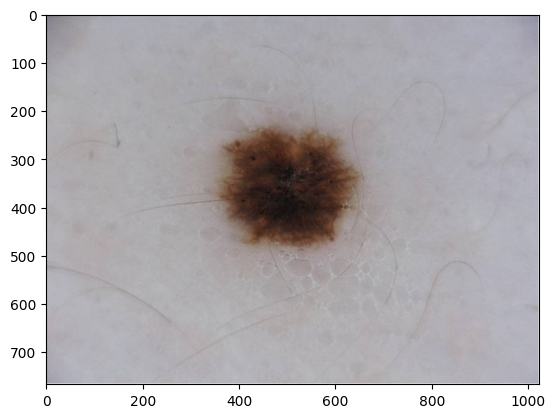

torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])
Min value before thresholding: -0.1272079348564148
Max value before thresholding: -0.11541980504989624
0.4682408571243286
0.47117704153060913
torch.Size([1, 1, 224, 224])
(224, 224)


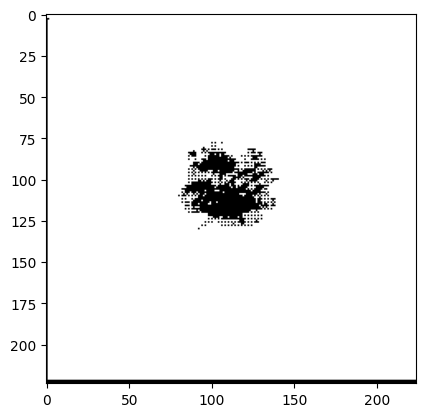

In [10]:
# Load the model
model = UNet(1)
#model.load_state_dict(torch.load('/content/Pytorch-UNet/unet_carvana.pth', map_location=torch.device('cpu')))  # Cambia la ruta según sea necesario
model.eval()

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

path = '/content/WhatsApp Image 2024-09-17 at 10.54.07 PM.jpeg'

#Load and preprocess input image(s)
input_image = Image.open(path)
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
plt.imshow(input_image, cmap='gray')
plt.show()

print(input_tensor.shape)
# Forward pass
with torch.no_grad():
    output = model(input_tensor)

# Imprimir los valores mínimos y máximos antes del umbral
print("Output shape:", output.shape)
print("Min value before thresholding:", output.min().item())
print("Max value before thresholding:", output.max().item())

# Aplicar sigmoid para obtener valores entre 0 y 1
output = torch.sigmoid(output)

# Obtener valores mínimos y máximos después de aplicar sigmoid
min_value = output.min().item()
max_value = output.max().item()
print(min_value)
print(max_value)

# Postprocess predictions (if needed)
# For example, convert output tensor to image and save
# You might also need to apply thresholding or other processing depending on the task
# Here's a simple example assuming output is a segmentation mask
# You would need to customize this based on y
print(output.shape)
output_image = output.squeeze().cpu().numpy()
print(output_image.shape)# Assuming output is a single-channel segmentation mask

# Umbralización ajustada
threshold_value = min_value + (max_value - min_value) * 0.5   # Ajusta este valor según sea necesario
output_image = (output_image > threshold_value).astype('uint8') * 255  # Umbralizar

output_image = Image.fromarray(output_image)
plt.imshow(output_image, cmap='gray')

In [60]:
#Original code
def calculateUNetSegmentation(train=1):
    segmented_images = []
    # Initialize variables for calculating the average Dice score
    if train == 1:
        segmentations = train_seg
        images_to_segment = train_images
    else:
        segmentations = test_seg
        images_to_segment = test_images

    # Process images in batches
    batch_size = 8  # Adjust as needed
    for i in range(0, len(segmentations), batch_size):
        batch_images = []
        for j in range(i, min(i+batch_size, len(segmentations))):
            image = Image.fromarray(images_to_segment[j][1])
            input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
            batch_images.append(input_tensor)

        # Concatenate input tensors to form a batch
        batch_input = torch.cat(batch_images, dim=0)

        # Move batch to GPU
        batch_input = batch_input.cuda()

        # Perform batch processing
        with torch.no_grad():
            batch_output = model(batch_input)

        # Move output back to CPU and process individual images
        batch_output = batch_output.cpu().numpy()

        for k in range(len(batch_images)):
            output_image = batch_output[k].squeeze()
            output_image = (output_image > 0.5).astype('uint8') * 255  # Thresholding
            resizedImage = resizeImage(images_to_segment[i+k][1], (output_image.shape[0], output_image.shape[1]))
            if segmentations[i+k] != -1:
                resizedTruthMaskImage = resizeImage(segmentations[i+k][1], (output_image.shape[0], output_image.shape[1]))
                segmented_images.append(cv2.bitwise_and(resizedImage, resizedImage, mask=resizedTruthMaskImage))
            else:
                segmented_images.append(cv2.bitwise_and(resizedImage, resizedImage, mask=output_image))

    return segmented_images

# Assuming 'model' and other variables are properly defined
# Ensure that 'transform' and 'resizeImage' functions are defined

# Move model to GPU if not already
if torch.cuda.is_available():
    model = model.cuda()

segmented_unet_train_images = calculateUNetSegmentation()
print("UNet segmentation for trained images done")
segmented_unet_test_images = calculateUNetSegmentation(train=0)
print("UNet segmentation for test images done")

NameError: name 'train_seg' is not defined

Output shape: (1, 1, 224, 224)
Min value before thresholding: -0.12720792
Max value before thresholding: -0.1154198
UNet segmentation for the single image done


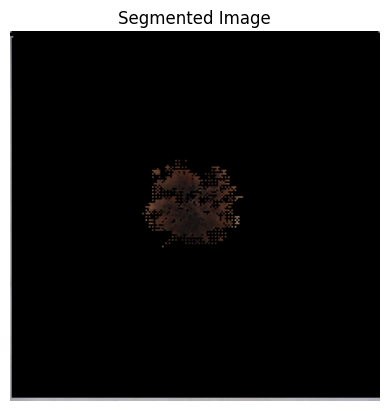

In [63]:
#Code for a single image
#implementa un proceso completo para realizar segmentación utilizando un modelo U-Net en lotes. Incluye preparación, procesamiento en GPU, umbralización y post-procesamiento para obtener imágenes segmentadas finales

import numpy as np
import cv2
import torch
from PIL import Image

def resizeImage(image, target_size):
    """Redimensiona la imagen a un nuevo tamaño especificado por target_size."""
    # Resize the image
    resized_img = cv2.resize(image, target_size)

    return resized_img

def calculateUNetSegmentationSingleImage(image, segmentation=None):
    segmented_images = []

    # Convert the input image to a PIL Image if it's not already
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    # Prepare the input tensor
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the input tensor to GPU
    input_tensor = input_tensor.cuda()

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)

   # Move output back to CPU and process the image
    output = output.cpu().numpy()

    # Imprimir los valores mínimos y máximos antes del umbral
    print("Output shape:", output.shape)
    print("Min value before thresholding:", output.min())
    print("Max value before thresholding:", output.max())

    output_image = output.squeeze()  # Remove any single-dimensional entries

    # Aplicar sigmoid si es necesario (si tu modelo no lo hace ya)
    output_image = torch.sigmoid(torch.tensor(output_image)).numpy()

    # Calcular un umbral dinámico basado en los valores mínimos y máximos
    min_value = output_image.min()
    max_value = output_image.max()

    # Establecer el umbral como un porcentaje del rango (puedes ajustar este porcentaje)
    threshold_value = min_value + (max_value - min_value) * 0.5  # 50% del rango

    # Apply thresholding
    output_image = (output_image < threshold_value).astype('uint8') * 255  # Thresholding

    # Resize the original image for display
    resizedImage = resizeImage(np.array(image), (output_image.shape[0], output_image.shape[1]))

    if segmentation is not None:
        resizedTruthMaskImage = resizeImage(segmentation, (output_image.shape[0], output_image.shape[1]))
        segmented_images.append(cv2.bitwise_and(resizedImage, resizedImage, mask=resizedTruthMaskImage))
    else:
        segmented_images.append(cv2.bitwise_and(resizedImage, resizedImage, mask=output_image))

    return segmented_images

    # Assuming 'model' and other variables are properly defined
# Ensure that 'transform' and 'resizeImage' functions are defined

# Move model to GPU if not already
if torch.cuda.is_available():
    model = model.cuda()

# Load a single image for testing
single_image_path = '/content/WhatsApp Image 2024-09-17 at 10.54.07 PM.jpeg'  # Cambia esto a la ruta de tu imagen
single_image = Image.open(single_image_path)

# Call the function for a single image
segmented_single_image = calculateUNetSegmentationSingleImage(single_image)  # , single_segmentation_mask)
print("UNet segmentation for the single image done")

# Access the first segmented image from the list
segmented_image_to_display = segmented_single_image[0]

# Display the segmented image using plt.imshow()
plt.imshow(segmented_image_to_display, cmap='gray')  # Cambia el índice según sea necesario
plt.axis('off')
plt.title('Segmented Image')
plt.show()